In [1]:
import torch
print(torch.__version__)

2.9.0+cpu


In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="images",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="images",
    train=False,
    download=True,
    transform=ToTensor()
)

In [3]:
import os 

lst_images = os.listdir("./images/FashionMNIST/raw")

print(lst_images[0])

t10k-images-idx3-ubyte.gz


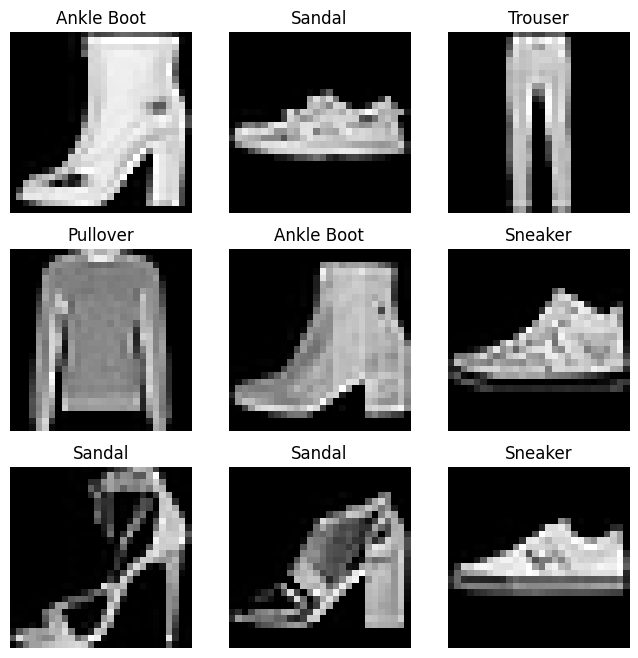

In [4]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# 1. Load and Vizualize a Single Tensor\n
Here we visualize a single sample from the training data, checking its shape and label.

Image Shape: torch.Size([1, 28, 28])
Label: 2 (Pullover)


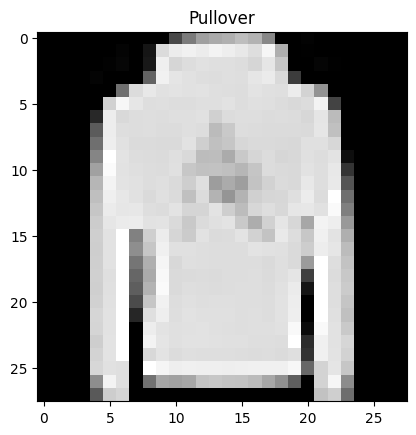

In [5]:
import torch

# We pick a random sample from the dataset we already loaded
# Note: training_data is already configured with transform=ToTensor(), 
# so 'img' is already a torch Tensor.
sample_idx = torch.randint(len(training_data), size=(1,)).item()
img, label = training_data[sample_idx]

print(f"Image Shape: {img.shape}")
print(f"Label: {label} ({labels_map[label]})")

# Visualize the tensor as an image
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(img.squeeze(), cmap="gray")
plt.title(f"{labels_map[label]}")
plt.show()

# 2. Create DataLoaders\n
We use DataLoaders to pass samples to our model in "batches".

In [6]:
from torch.utils.data import DataLoader

batch_size = 64

# Create data loaders
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


# 3. Define the CNN Model\n
A simple CNN with 2 convolutional layers, max pooling, and fully connected layers.

In [7]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            # Conv Layer 1: 1 input channel (grayscale), 32 filters, 3x3 kernel
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv Layer 2: 32 input channels, 64 filters
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # After 2 poolings (div by 2 twice), 28x28 -> 14x14 -> 7x7
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, 10)  # 10 output classes
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
model = SimpleCNN().to(device)
print(model)

Using device: cpu
SimpleCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=10, bias=True)
  )
)


# 4. Training and Evaluation Loops

In [8]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()  # Set to training mode
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    model.eval()  # Set to evaluation mode
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

# 5. Run Training

In [9]:
learning_rate = 1e-3
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.294374  [   64/60000]
loss: 0.438925  [ 6464/60000]
loss: 0.454980  [12864/60000]
loss: 0.366579  [19264/60000]
loss: 0.788721  [25664/60000]
loss: 0.168680  [32064/60000]
loss: 0.309735  [38464/60000]
loss: 0.388609  [44864/60000]
loss: 0.237673  [51264/60000]
loss: 0.258668  [57664/60000]
Test Error: 
 Accuracy: 88.3%, Avg loss: 0.318610 

Epoch 2
-------------------------------
loss: 0.173605  [   64/60000]
loss: 0.327372  [ 6464/60000]
loss: 0.217855  [12864/60000]
loss: 0.213647  [19264/60000]
loss: 0.173827  [25664/60000]
loss: 0.333357  [32064/60000]
loss: 0.252723  [38464/60000]
loss: 0.159427  [44864/60000]
loss: 0.240699  [51264/60000]
loss: 0.302677  [57664/60000]
Test Error: 
 Accuracy: 90.4%, Avg loss: 0.262195 

Epoch 3
-------------------------------
loss: 0.436916  [   64/60000]
loss: 0.145962  [ 6464/60000]
loss: 0.197853  [12864/60000]
loss: 0.199091  [19264/60000]
loss: 0.207707  [25664/60000]
loss: 0.220082  [32064/600

# 6. Save and Load Model

In [10]:
# Save the Model
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

# Load the Model (verification)
model = SimpleCNN().to(device)
model.load_state_dict(torch.load("model.pth"))
print("Loaded PyTorch Model State from model.pth")

Saved PyTorch Model State to model.pth
Loaded PyTorch Model State from model.pth


# 7. Visual Verification of Predictions\n
Let's visualize some predictions on random test images to see how well the model works.

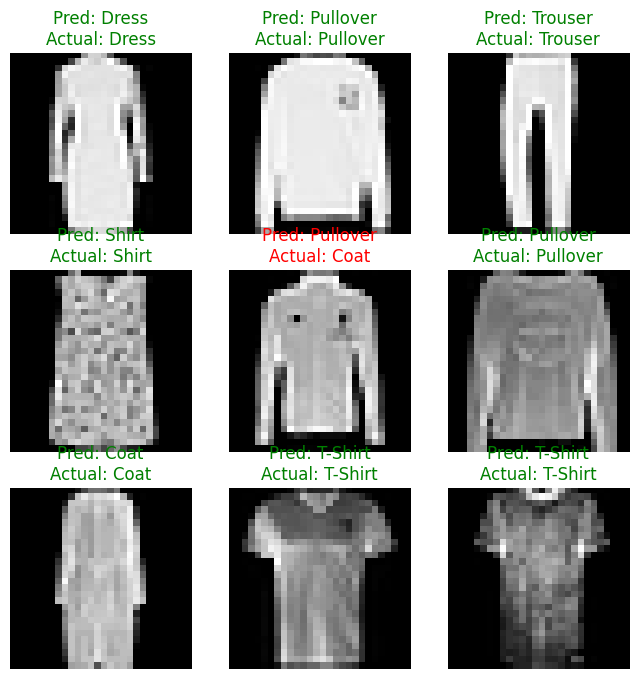

In [11]:
model.eval()
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
with torch.no_grad():
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(test_data), size=(1,)).item()
        img, label = test_data[sample_idx]
        img = img.to(device)
        
        # Predict
        pred = model(img.unsqueeze(0))
        predicted_label = pred.argmax(1).item()
        
        figure.add_subplot(rows, cols, i)
        color = "green" if predicted_label == label else "red"
        plt.title(f"Pred: {labels_map[predicted_label]}\nActual: {labels_map[label]}", color=color)
        plt.axis("off")
        plt.imshow(img.cpu().squeeze(), cmap="gray")
plt.show()